# Train and deploy a simple employee promotion prediction model
This notebook demonstrates a new approach with [SAP Federated ML Python libraries (FedML)](https://pypi.org/project/fedml-dsp/) for an end-to-end workflow in a predictive analytics use case, in which you train a classification model with data from [SAP Datasphere](https://help.sap.com/docs/SAP_DATASPHERE), deploy the model to [SAP AI Core](https://help.sap.com/docs/sap-ai-core), and use it for online inference. Comparing with other similar notebooks in this GitHub repository without SAP FedML, far less coding is needed to achieved the same results with FedML, which leverages SAP Datasphere's Data Federation architecture to intelligently source both SAP and non-SAP data for machine learning experiments. We developed and tested this notebook in [IBM® watsonx.ai™ AI studio](https://www.ibm.com/products/watsonx-ai), but you should be able to run it in any Jupyter notebook environment you prefer with little or no code change.

In this notebook, you will learn:

- How to access datasets stored in SAP Datasphere using FedML
- How to train a Random Forest Classification model using Scikit-Learn
- How to serve the model in SAP AI Core using FedML
- How to make inference calls using FedML

###  More about the use case
This notebook demonstrates the implementation of a Random Forest Classification model for predicting employee promotions. Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees for robust and accurate predictions. To help understand and implement the Random Forest algorithm for predicting employee promotions, this notebook covers the process of extracting relevant features, training the Random Forest model, and evaluating its performance in predictions. Employee promotion prediction involves identifying factors that contribute to promotion decisions based on various features. The focus is on leveraging model training with employee historical data for accurate predictions.

## Table of Contents
1.  [Step 1: Connect to SAP Datasphere](#connect_dsp)

1.  [Step 2: Load and prepare the data](#load_data)

1.  [Step 3: Balance the dataset](#balance_dataset)

1.  [Step 4: Data Preprocessing and Train-Test split](#process_data)

1.  [Step 5: Train the Random forest classifier model](#train_model)

1.  [Step 6: Model Evaluation](#evaluate_data)

1.  [Step 7: Save the model as pickle](#save_model)

1.  [Step 8: Deploy the model to SAP AI Core](#deploy_to_aicore)

1.  [Step 9: Make predictions](#make_predictions)


### Credentials

You need to provide the credentials required for accessing SAP Datasphere, SAP AI Core, GitHub repository, Docker registry, and IBM Cloud Object Storage (COS). Details about their parameters can be found in the documentation:
- https://github.com/SAP-samples/datasphere-fedml/blob/main/Datasphere/fedml-dsp.md
- https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-python

```
fedml_config = {
    "address":  <The IP address or host name of the database instance. Required. String>,
    "port": <The port number of the database instance. Required>,
    "user": <The database user. Required>,
    "password": <The database user's password. Required>,
    "schema": <The SAP Datasphere cloud Space Schema. Optional>,
    "encrypt": <"true" . Denotes an encrypted connection>,
    "sslValidateCertificate": <"false" . Specifies whether to validate the server's certificate>,
    "disableCloudRedirect": < "true". Specifies if there should be a tenant redirection for a cloud instance,
    "communicationTimeout": <"0". Value of 0 Disables any communication Timeouts>,
    "autocommit": <"true". Sets auto commit to true for the database connection>,
    "sslUseDefaultTrustStore": <"true". Denotes the use of client's default trust store>
}

aicore_service_key = {
    "serviceurls": {
        "AI_API_URL": "https://api.ai.xxx.yyy.zzz.ml.hana.ondemand.com"
    },
    "appname": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx!xxxxxxx|aicore!xxxx",
    "clientid": "sb-xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx!xxxxxxx|aicore!xxxx",
    "clientsecret": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx$abcdefgh1234567890abcdefgh1234567890abcdefgh',
    "identityzone": "xyz123",
    "identityzoneid": "xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx",
    "url": "https://xyz123.authentication.us10.hana.ondemand.com"
}

github_info = {
    "name": "<name>",
    "url": "<url>",
    "username": "<username>",
    "password": "<password>"
}

docker_registry_secret = {
    "name": "<name_of_secret>",
    "data": {
        ".dockerconfigjson": "{\"auths\":{\"https://index.docker.io\":{\"username\":\"<username>\",\"password\":\"<password>\"}}}"
    }
}

object_storage_credential = {
    'access_key_id' = '<your_access_key_id>',
    'secret_access_key' = '<your_secret_access_key>',
    'bucket' = '<your_bucket>',
    'endpoint' = '<host>',
    'region' = '<region>'
}

cos_credential = {
    'COS_INSTANCE_ID': '<cos_instance_crn>',
    'COS_API_KEY': '<cos_api_key>',
    'COS_ENDPOINT': 'https://s3.<region>.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': '<bucket>',
}
```

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import os, types
import time
import json
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import requests

In [3]:
# Save fedml_config to a JSON file
with open("fedml_config.json", "w") as outfile: 
    json.dump(fedml_config, outfile, indent = 4)

# Save aicore_service_key to a JSON file
with open("aicore_service_key.json", "w") as outfile: 
    json.dump(aicore_service_key, outfile, indent = 4)

# Save github_info to a JSON file
with open("github_info.json", "w") as outfile: 
    json.dump(github_info, outfile, indent = 4)

# Save docker_registry_secret to a JSON file
with open("docker_registry_secret.json", "w") as outfile: 
    json.dump(docker_registry_secret, outfile, indent = 4)

<a id="load_data"></a>
## Step 1: Connect to SAP Datasphere

Install SAP FedML library.

In [4]:
try:
    import fedml_dsp
    from fedml_dsp import DbConnection
except:
    %pip install -U fedml-dsp
    import fedml_dsp
    from fedml_dsp import DbConnection

No Nvidia GPU in system!


Create a connection to SAP Datasphere.

In [5]:
db = DbConnection(url='fedml_config.json')

2024-04-18 04:43:26,835: fedml_dsp.logger INFO: Attempting DSP check.
2024-04-18 04:43:27,025: fedml_dsp.logger INFO: DSP check completed. Connected to DSP.


Seach for the training data stored in Datasphere, which is exposed as a view named "epp_train_view".

In [6]:
db.get_view_by_name("epp_train_view")

2024-04-18 04:43:27,038: fedml_dsp.logger INFO: Searching for views with name 'epp_train_view' in schema 'WATSONX'


([('epp_train_view', 'ROW')], ['VIEW_NAME', 'VIEW_TYPE'])

<a id="load_data"></a>
## Step 2: Load and prepare the data

Fetch the the training data from SAP Datasphere, and save it in a pandas DataFrame.

In [7]:
data = db.get_data_with_headers("epp_train_view")
employee_data = pd.DataFrame(data[0], columns=data[1])
employee_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,any_awards_won,is_promoted,kpis_met_above_80_percent,avg_training_score
0,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,None,1,0,0,0,49
1,66874,Sales & Marketing,region_27,Bachelor's,f,other,1,30,None,1,0,0,0,50
2,36904,Sales & Marketing,region_15,Bachelor's,m,other,1,29,3,2,0,0,0,51
3,32877,Sales & Marketing,region_2,Bachelor's,f,other,1,40,3,12,0,0,0,50
4,58415,Sales & Marketing,region_7,Bachelor's,m,other,1,45,4,5,0,0,0,50


In [8]:
employee_data.dtypes

employee_id                   int64
department                   object
region                       object
education                    object
gender                       object
recruitment_channel          object
no_of_trainings               int64
age                           int64
previous_year_rating         object
length_of_service             int64
any_awards_won                int64
is_promoted                   int64
kpis_met_above_80_percent     int64
avg_training_score            int64
dtype: object

In [9]:
# Change dtype
employee_data['previous_year_rating'] = pd.to_numeric(employee_data['previous_year_rating'])

# Change the order of the columns
employee_data = employee_data[['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_above_80_percent', 'any_awards_won',
       'avg_training_score', 'is_promoted']]

employee_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_above_80_percent,any_awards_won,avg_training_score,is_promoted
0,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
1,66874,Sales & Marketing,region_27,Bachelor's,f,other,1,30,NaN,1,0,0,50,0
2,36904,Sales & Marketing,region_15,Bachelor's,m,other,1,29,3.0,2,0,0,51,0
3,32877,Sales & Marketing,region_2,Bachelor's,f,other,1,40,3.0,12,0,0,50,0
4,58415,Sales & Marketing,region_7,Bachelor's,m,other,1,45,4.0,5,0,0,50,0


In [10]:
employee_data.dtypes

employee_id                    int64
department                    object
region                        object
education                     object
gender                        object
recruitment_channel           object
no_of_trainings                int64
age                            int64
previous_year_rating         float64
length_of_service              int64
kpis_met_above_80_percent      int64
any_awards_won                 int64
avg_training_score             int64
is_promoted                    int64
dtype: object

In [11]:
employee_data.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_above_80_percent', 'any_awards_won',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [12]:
employee_data = employee_data.drop(columns=["employee_id", "recruitment_channel", "region"])

In [13]:
employee_data.shape

(54808, 11)

<a id="balance_dataset"></a>
## Step 3: Balance the dataset

Balancing the dataset with respect to the "is_promoted" variable is essential to avoid bias in the predictive model. When the dataset is imbalanced, with one class significantly outnumbering the other (e.g., promoted or not promoted employees), the model may exhibit a tendency to favor the majority class. In the context of employee promotion prediction, imbalance could lead to inaccurate predictions, especially if the majority of instances involve non-promotion.

In [14]:
# Separate the two classes
n = employee_data[employee_data['is_promoted'] == 1].count()[0]
class_0_data = employee_data[employee_data['is_promoted'] == 0]
class_1_data = employee_data[employee_data['is_promoted'] == 1]
print(employee_data['is_promoted'].value_counts())
# Take 3760 samples from class 0
class_0_sampled = class_0_data.sample(n, random_state=42)

# Combine the two classes to create a balanced dataset
employee_data = pd.concat([class_0_sampled, class_1_data])
print(employee_data['is_promoted'].value_counts())

0    50140
1     4668
Name: is_promoted, dtype: int64
0    4668
1    4668
Name: is_promoted, dtype: int64


In [15]:
employee_data.reset_index(drop=True,inplace=True)

<a id="process_data"></a>
## Step 4: Data Preprocessing and Train-Test split
Data preprocessing, including handling missing values, encoding categorical columns, and splitting the dataset into training and test sets, with a check on the class distribution in the training data.

In [16]:
# Handle missing values
employee_data["education"].fillna(employee_data["education"].mode()[0], inplace=True)
employee_data["previous_year_rating"].fillna(1, inplace=True)

# Encode categorical columns
categorical_columns = employee_data.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(employee_data, columns=categorical_columns, drop_first=True)

# Split the data into features (X) and target (y)
y = X_encoded["is_promoted"]
X_encoded = X_encoded.drop("is_promoted", axis=1)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initializing a Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Check the class distribution in the training set
class_counts = y_train.value_counts()
print("Class Distribution in Training Data:")
print(class_counts)

Class Distribution in Training Data:
0    3737
1    3731
Name: is_promoted, dtype: int64


<a id="train_model"></a>
## Step 5: Train the Random Forest Classifier model
Initialization, training, and testing of a Random Forest Classifier with balanced class weights for predicting promotions in an employee dataset.

In [17]:
# Initialize a Random Forest Classifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)

# Training the model
rf_classifier.fit(X_train, y_train)

# Testing data prediction
y_pred = rf_classifier.predict(X_test)

# Traing data prediction
yt_pred = rf_classifier.predict(X_train)

In [18]:
# List of feature columns 
X_encoded.columns

Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'kpis_met_above_80_percent', 'any_awards_won', 'avg_training_score',
       'department_Finance', 'department_HR', 'department_Legal',
       'department_Operations', 'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Bachelor's', 'education_Below Secondary',
       'education_Master's & above', 'gender_m'],
      dtype='object')

<a id="evaluate_data"></a>
## Step 6: Model Evaluation
Evaluating the training and testing accuracy scores of a Random Forest Classifier for employee promotion prediction.

In [19]:
# Calculating accuracy
train_accuracy = accuracy_score(y_train, yt_pred)

print("train_accuracy",train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred)

print("test_accuracy",test_accuracy)

train_accuracy 0.9965184788430638
test_accuracy 0.8094218415417559


In [20]:
# Testing data 
pred_df={
    'no_of_trainings': {0: 1, 1: 1, 2: 1, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1},
    'age': {0: 35, 1: 30, 2: 34, 3: 39, 4: 45, 5: 31, 6: 31, 7: 33, 8: 28, 9: 32},
    'previous_year_rating': {0: 5.0, 1: 5.0, 2: 3.0, 3: 1.0, 4: 3.0, 5: 3.0, 6: 3.0, 7: 3.0, 8: 4.0, 9: 5.0},
    'length_of_service': {0: 8, 1: 4, 2: 7, 3: 10, 4: 2, 5: 7, 6: 5, 7: 6, 8: 5, 9: 5},
    'kpis_met_above_80_percent': {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1},
    'any_awards_won': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'avg_training_score': {0: 49, 1: 60, 2: 50, 3: 50, 4: 73, 5: 85, 6: 59, 7: 63, 8: 83, 9: 54},
    'department_Finance': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'department_HR': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'department_Legal': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'department_Operations': {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0},
    'department_Procurement': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'department_R&D': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    'department_Sales & Marketing': {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1},
    'department_Technology': {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    "education_Bachelor's": {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0},
    'education_Below Secondary': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
    "education_Master's & above": {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1},
    'gender_m': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1}
}
pred_df=pd.DataFrame(pred_df)

In [21]:
y_prob = rf_classifier.predict_proba(pred_df)
y_prob

array([[0.18, 0.82],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.92, 0.08],
       [0.74, 0.26],
       [0.96, 0.04],
       [0.91, 0.09],
       [0.79, 0.21],
       [0.57, 0.43]])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision
precision = precision_score(y_test, y_pred)
print(precision)

# Compute recall
recall = recall_score(y_test, y_pred)
print(recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7873392680514342
0.8495197438633938
0.8172484599589321


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       931
           1       0.79      0.85      0.82       937

    accuracy                           0.81      1868
   macro avg       0.81      0.81      0.81      1868
weighted avg       0.81      0.81      0.81      1868

F1 Score: 0.82
Recall: 0.85
Precision: 0.79
AUC Score: 0.89


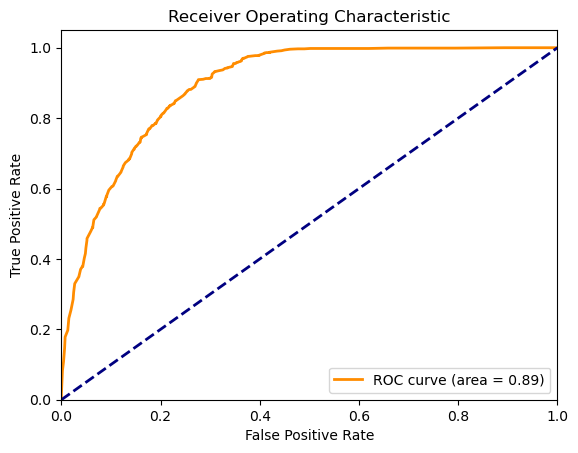

In [23]:
# Get predicted probabilities for class 1
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# custom_threshold = 0.4  # You can adjust this value
# y_pred = (y_prob >= custom_threshold).astype(int)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<a id="save_model"></a>
## Step 7: Save the model as pickle
Saving a trained Random Forest Classifier model to a file and uploading it to a COS bucket for the next step. The Dockerfile found in the `container` directory, along with other files in it, can be used to build a runtime container image for serving the model on Docker, SAP AI Core, and other cloud container environments.

In [24]:
import joblib

# Save the model to a file
joblib.dump(rf_classifier, 'epp.pkl')

['epp.pkl']

In [25]:
from ibm_botocore.client import Config
import ibm_boto3

client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id=cos_credential['COS_API_KEY'],
    ibm_service_instance_id=cos_credential['COS_INSTANCE_ID'],
    ibm_auth_endpoint=cos_credential['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credential['COS_ENDPOINT']
)

try:
    client.upload_file(Bucket=cos_credential['BUCKET'], Filename='epp.pkl', Key='scikit_model.pkl')
except Exception as e:
    print(Exception, e)
else:
    print('File Uploaded')

File Uploaded


<a id="deploy_to_aicore"></a>
## Step 8: Deploy the model to SAP AI Core

Before deploying a machine learning model to SAP AI Core, you need to initializes the connection to AI Core.

In [26]:
from fedml_dsp import Fedml

try:
    fedml = Fedml(aic_service_key='aicore_service_key.json')
except:
    raise Exception("FedML constructor failed.")

2024-04-17 03:48:45,624: fedml_dsp.logger INFO: Creating AI Core Connection ....
2024-04-17 03:48:45,626: fedml_dsp.logger INFO: Sucessfully Created AI Core Connection


Then, you need to onboard any ai core resources required, including your github repository, AI core resource group, and secret to provide AI core pull permissions to your Docker registry.

In [27]:
try:
    fedml.onboard_ai_core(
        create_resource_group=False,
        resource_group='default',
        onboard_new_repo=True,
        github_info_path="github_info.json",
        secret_path="docker_registry_secret.json"
    )
except:
    raise Exception("AI Core resource onboarding failed.")

2024-04-17 03:48:45,640: fedml_dsp.logger INFO: Onboarding Github Repository....
Name: aicore-fedml-demo
URL: https://github.com/kevinxhuang/aicore-fedml-demo.git
Status: RepositoryStatus.COMPLETED
2024-04-17 03:48:47,729: fedml_dsp.logger INFO: Creating secret....
2024-04-17 03:48:48,233: fedml_dsp.logger INFO: {'message': 'secret has been created'}


Next, you can register a new application in AI Core. If you want to use an existing AI Core application for your deployment, skip this step.

In [28]:
APPLICATION_NAME = "fedml-demo-app"

try:
    application_details = {
        "application_name": APPLICATION_NAME, 
        "revision": "HEAD", 
        "repository_url": "https://github.com/kevinxhuang/aicore-fedml-demo.git", 
        "path": "demo-deployment"
    }

    fedml.register_application(application_details=application_details)
except:
    raise Exception("Application registration failed.")

2024-04-17 03:48:52,715: fedml_dsp.logger INFO: {'id': 'fedml-demo-app', 'message': 'Application has been successfully created.'}
2024-04-17 03:48:57,868: fedml_dsp.logger INFO: successfully synced (all tasks run)


Assuming you have built an image and pushed it to the Docker registry, you can now start the deployment of your application to AI Core.

In [29]:
try:
    deployment_config = {
        "name": APPLICATION_NAME, 
        "resource_group": "default", 
        "scenario_id": "fedml-demo", 
        "executable_id": "fedml-demo-serving-exectuable-20240404"
    }

    time.sleep(60)
    deployment_url = fedml.ai_core_deploy(deployment_config=deployment_config)
except:
    raise Exception("Deployment to AI Core failed")

2024-04-17 03:49:58,625: fedml_dsp.logger INFO: {'id': 'a4120b99-88c2-43fb-9692-446f0ce8da92', 'message': 'Configuration created'}
2024-04-17 03:49:59,166: fedml_dsp.logger INFO: {'id': 'a4120b99-88c2-43fb-9692-446f0ce8da92', 'name': 'fedml-demo-app', 'scenario_id': 'fedml-demo', 'executable_id': 'fedml-demo-serving-exectuable-20240404', 'parameter_bindings': [], 'input_artifact_bindings': [], 'created_at': datetime.datetime(2024, 4, 17, 3, 49, 58, tzinfo=datetime.timezone.utc), 'scenario': None}
2024-04-17 03:49:59,660: fedml_dsp.logger INFO: {'id': 'd12da55bdfde7c9c', 'message': 'Deployment scheduled.', 'deployment_url': '', 'status': <Status.UNKNOWN: 'UNKNOWN'>, 'ttl': None}
2024-04-17 03:50:15,167: fedml_dsp.logger INFO: Deployment status....Status.UNKNOWN
2024-04-17 03:50:30,718: fedml_dsp.logger INFO: Deployment status....Status.UNKNOWN
2024-04-17 03:50:46,240: fedml_dsp.logger INFO: Deployment status....Status.UNKNOWN
2024-04-17 03:51:05,851: fedml_dsp.logger INFO: Deployment st

In [30]:
deployment_url

'https://api.ai.prod.us-east-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d12da55bdfde7c9c/v2/invocations'

<a id="make_predictions"></a>
## Step 9: Make predictions
Finally, after deployment is done, you can run inference on your deployed model.

In [31]:
base_url = aicore_service_key["serviceurls"]["AI_API_URL"] + "/v2/inference/deployments/" + deployment_url[-31:-15]
base_url

'https://api.ai.prod.us-east-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d12da55bdfde7c9c'

You can use FedML library to make an inference call. The `fedml.get_ai_core_token()` function can retrieve an authorization token needed to make inferencing calls to SAP AI Core. The `ai_core_inference(endpoint, headers, body)` function makes an API call to the inference endpoint and returns a response.

In [32]:
# Prepare a sample input
sample_input = {
    'input_data': [
        {
            'fields': [
                'no_of_trainings',
                'age',
                'previous_year_rating',
                'length_of_service',
                'kpis_met_above_80_percent',
                'any_awards_won', 'avg_training_score',
                'department_Finance',
                'department_HR', 'department_Legal',
                'department_Operations', 'department_Procurement',
                'department_R&D', 'department_Sales & Marketing',
                'department_Technology',
                "education_Bachelor's",
                'education_Below Secondary',
                "education_Master's & above",
                'gender_m'],
            'values': [[1,33,3,6,0,0,63,0,0,0,1,0,0,0,0,0,0,1,1]]
        }
    ]
}

# Make an inference call
try:
    endpoint = f"{base_url}/v2/predict" # endpoint implemented in serving engine
    headers = {"Authorization": fedml.get_ai_core_token(),
               "AI-Resource-Group": "default",
               "Content-Type": "application/json"}

    response = fedml.ai_core_inference(
        endpoint=endpoint,
        headers=headers,
        body=json.dumps(sample_input)
    )

    print(response)
    print(response.json())
except:
    raise Exception("Model inferencing failed.")

<Response [200]>
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.95, 0.05]]]}]}
